In [1]:
import sys
sys.path.append('..')
import alfw
from alfw import Face, lmnames, goodmarksnames, split
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

from keras.initializations import *
from keras.models import Model
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as K
import keras
from theano.sandbox.cuda.dnn import *
import sklearn.metrics
import scipy

In [3]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(200000, onlyvisible=True)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
Xtest, ytest, hts = scale( Xtest, ytest, hts )

loading..
im.shape:  (21776, 128, 128, 3)
feats.shape: (21776, 28, 2)
hogs.shape: (21776, 8100)
goodmarks  (12, 21776, 2)
assert  0
mask  (21776,)
8166 21776
mmm  (21776, 12, 2)
418769
rim.shape:  (8166, 128, 128, 3)
rfeats.shape: (8166, 12, 2)
rhogs.shape: (8166, 8100)
(7349, 8100)
(8100,)
ytrain.shape  (7349, 12, 2)
meany.shape  (12, 2)
stdy.shape  (12, 2)
(7349, 128, 128, 3)
()
mmm  (7349, 12, 2)
ytrain  (7349, 12, 2)
(7349, 128, 128, 3)
mean  (7349, 128, 128)


### a look at data
Y is in [-1 1]

(7349, 128, 128, 1)


(array([  6.30000000e+01,   5.51500000e+03,   4.25140000e+04,
          2.82720000e+04,   2.05530000e+04,   3.04850000e+04,
          2.83770000e+04,   1.87600000e+04,   1.81800000e+03,
          1.90000000e+01]),
 array([-0.875     , -0.69456714, -0.51413428, -0.33370141, -0.15326855,
         0.02716431,  0.20759717,  0.38803004,  0.5684629 ,  0.74889576,
         0.92932862]),
 <a list of 10 Patch objects>)

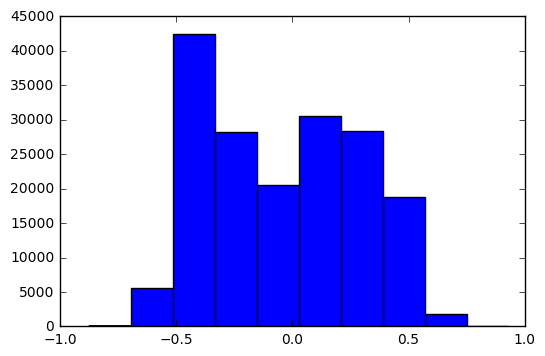

In [4]:
print Xtrain.shape
plt.hist(ytrain.flatten())

## Define a simple mlp / cnn with one hidden layer using KERAS

In [5]:
# simple mlp
# input is 2D grey scale
inputs = Input((1, alfw.size, alfw.size))

In [6]:
if False :
    flat = Flatten()(inputs)
    # flatten before feeding to fully connected
    hidden = Dense(400, activation='relu')(flat)
    for i in range(4):
        hidden = Dense(400, activation='relu')(hidden)

In [55]:
conv1 = Convolution2D(10, 5, 5, subsample=(2,2), activation='relu')(inputs)
conv = Convolution2D(10, 3, 3, activation='relu')(conv1)
hidden = Flatten()(conv)

In [8]:
# output
hidden = Dense(400, activation='relu')(hidden)
h1 = Dense(ytrain.shape[1]*2)(hidden)
out = Reshape((ytrain.shape[1], 2))(h1)
model = Model(input=inputs, output=out)

In [9]:
# define the optimizer : stochastic gradient descent
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

In [10]:
model.compile(loss='mean_squared_error', optimizer=sgd)
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 10, 63, 63)    100         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 61, 61)    910         convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 37210)         0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
history = model.fit(np.transpose(Xtrain, (0, 3, 1, 2)),
                    ytrain,
                    batch_size=128,
                    nb_epoch=20, verbose=2, shuffle=True,
                    validation_split = 0.3)

Train on 5144 samples, validate on 2205 samples
Epoch 1/20
2s - loss: 0.0192 - val_loss: 0.0101
Epoch 2/20
2s - loss: 0.0084 - val_loss: 0.0100
Epoch 3/20
1s - loss: 0.0083 - val_loss: 0.0099
Epoch 4/20
1s - loss: 0.0082 - val_loss: 0.0098
Epoch 5/20
2s - loss: 0.0081 - val_loss: 0.0097
Epoch 6/20
2s - loss: 0.0080 - val_loss: 0.0096
Epoch 7/20
1s - loss: 0.0079 - val_loss: 0.0097
Epoch 8/20
2s - loss: 0.0077 - val_loss: 0.0094
Epoch 9/20
1s - loss: 0.0076 - val_loss: 0.0092
Epoch 10/20
1s - loss: 0.0074 - val_loss: 0.0090
Epoch 11/20
1s - loss: 0.0072 - val_loss: 0.0087
Epoch 12/20
2s - loss: 0.0069 - val_loss: 0.0085
Epoch 13/20
2s - loss: 0.0067 - val_loss: 0.0083
Epoch 14/20
2s - loss: 0.0065 - val_loss: 0.0083
Epoch 15/20
1s - loss: 0.0064 - val_loss: 0.0080
Epoch 16/20
2s - loss: 0.0062 - val_loss: 0.0078
Epoch 17/20
2s - loss: 0.0061 - val_loss: 0.0077
Epoch 18/20
2s - loss: 0.0060 - val_loss: 0.0076
Epoch 19/20
1s - loss: 0.0059 - val_loss: 0.0075
Epoch 20/20
2s - loss: 0.0058 

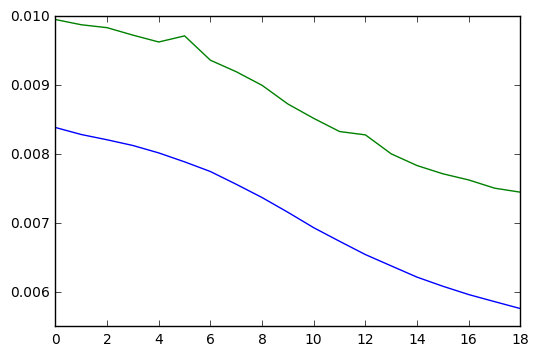

In [12]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )

(817, 128, 128, 1)
(128, 128) (817, 12, 2)


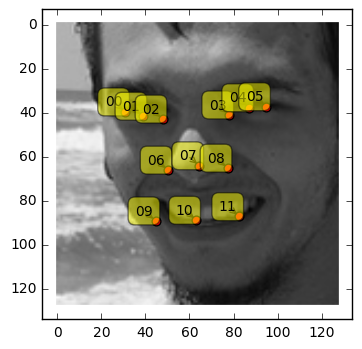

In [13]:
pred = unscale(model.predict(np.transpose(Xtest, (0, 3, 1, 2))))
print Xtest1.shape
exim = Xtest1.reshape(Xtest1.shape[0], Xtest1.shape[1], Xtest1.shape[2])[31,:,:]/255
print exim.shape, pred.shape
alfw.draw(np.dstack((exim, exim, exim)), pred[31, :, :])
#print pred[31,:,:]

rmse =  6.50275113824


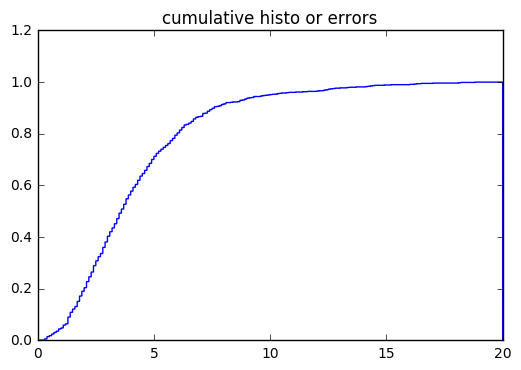

In [188]:

feat=0
predpos = pred[:, feat, :].T
gtpos = unscale(ytest)
gtpos = gtpos[:,feat,:].T
dist = np.linalg.norm(predpos - gtpos, 2, axis=0)
rmse = np.sqrt(np.mean(np.square(dist)))
print 'rmse = ', rmse
#n, bins, patches = plt.hist(dist, 200,)
plt.title('cumulative histo or errors')
n, bins, patches = plt.hist(dist, 200, normed=1,   histtype='step', cumulative=True, range=(0, 20))


## classification gender

play with data augmentation
cnn structure (maxpooling, conv layers)



In [16]:
genders = np.asarray([x.genre == 'f' for x in d['md'][0]])
genders_test = np.asarray([x.genre == 'f' for x in d['md'][1]])
print genders[20:]*1
print genders.shape

[1 1 0 ..., 1 1 0]
(7349,)


In [171]:
conv01 = Convolution2D(32, 5, 5, subsample=(2,2), activation='relu')(inputs)
conv2 = Convolution2D(32, 3, 3, activation='relu')(conv01)
mp1 = MaxPooling2D((2,2))(conv2)
conv2 = Convolution2D(64, 3,3, activation='relu')(mp1)
conv3 = Convolution2D(64, 3,3, activation='relu')(conv2)
mp2 = MaxPooling2D((2,2))(conv3)
f = Flatten()(mp2)
h2 = Dense(16)(f)
h1 = Dense(1, activation='sigmoid')(h2)
modelGender = Model(input=inputs, output=h1)
sgd = SGD(lr=0.0051, momentum=0.9, nesterov=True, decay=1e-6)
modelGender.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelGender.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_37 (Convolution2D) (None, 32, 62, 62)    832         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 32, 60, 60)    9248        convolution2d_37[0][0]           
____________________________________________________________________________________________________
maxpooling2d_42 (MaxPooling2D)   (None, 32, 30, 30)    0           convolution2d_38[0][0]           
___________________________________________________________________________________________

## Augmenting the data

In [172]:
print Xtrain.shape
XtrainM = Xtrain[:,:,::-1,:]
print XtrainM.shape

XtrainA = np.concatenate((Xtrain, XtrainM), axis=0)
gendersA = np.concatenate((genders, genders), axis=0)

(7349, 128, 128, 1)
(7349, 128, 128, 1)


In [173]:
history = modelGender.fit(np.transpose(XtrainA, (0, 3, 1, 2)),
                    (gendersA*1).astype(np.float32),
                    batch_size=128,
                    nb_epoch=10, verbose=1, shuffle=True,
                    validation_split = 0.3)

Train on 10288 samples, validate on 4410 samples
Epoch 1/10
10288/10288 [==============================] - 9s - loss: 0.6777 - acc: 0.5542 - val_loss: 0.6497 - val_acc: 0.6336
Epoch 2/10
10288/10288 [==============================] - 9s - loss: 0.6200 - acc: 0.6631 - val_loss: 0.5758 - val_acc: 0.7063
Epoch 3/10
10288/10288 [==============================] - 9s - loss: 0.5966 - acc: 0.6862 - val_loss: 0.6410 - val_acc: 0.6288
Epoch 4/10
10288/10288 [==============================] - 9s - loss: 0.5722 - acc: 0.7036 - val_loss: 0.5342 - val_acc: 0.7361
Epoch 5/10
10288/10288 [==============================] - 9s - loss: 0.5346 - acc: 0.7294 - val_loss: 0.4975 - val_acc: 0.7615
Epoch 6/10
10288/10288 [==============================] - 9s - loss: 0.5015 - acc: 0.7568 - val_loss: 0.4900 - val_acc: 0.7624
Epoch 7/10
10288/10288 [==============================] - 9s - loss: 0.4780 - acc: 0.7675 - val_loss: 0.4617 - val_acc: 0.7844
Epoch 8/10
10288/10288 [==============================] - 8s -

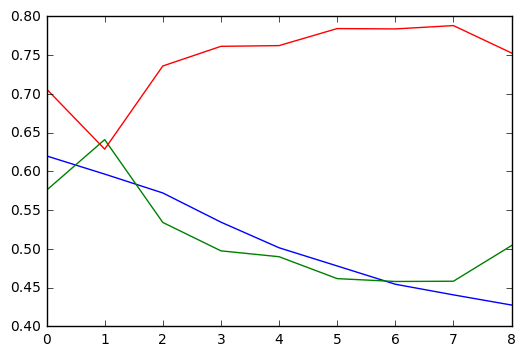

In [174]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )
plt.plot(history.history['val_acc'][1:], color='red' )


(array([ 365.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  452.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

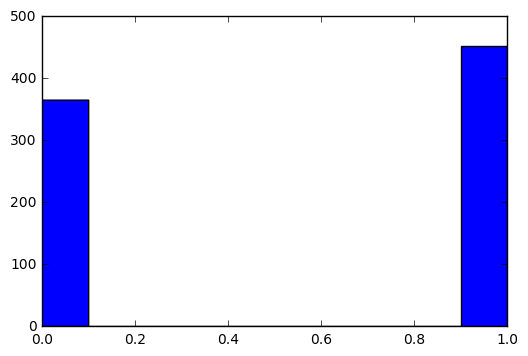

In [175]:
plt.hist(genders_test*1)

(817,)
accuracy 0.866965692811
0.782129742962


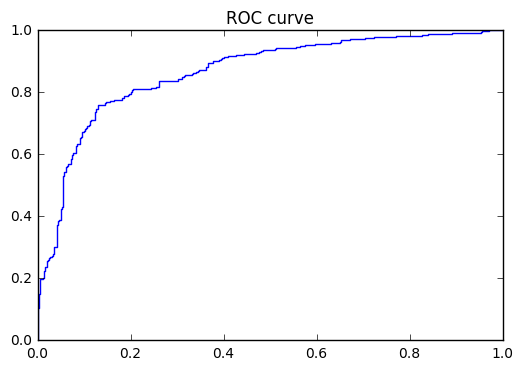

In [178]:
predtest = modelGender.predict(np.transpose(Xtest, (0, 3, 1, 2)))[:,0]
print predtest.shape
print 'accuracy',  sklearn.metrics.roc_auc_score(genders_test * 1 , predtest)
print sklearn.metrics.accuracy_score(genders_test * 1 , predtest>0.5)
fp, tp, _ = sklearn.metrics.roc_curve(genders_test * 1 , predtest)
plt.title('ROC curve')
plt.plot(fp, tp)



In [177]:
print Xtest.shape
modelGender.predict(np.transpose(Xtest[31:32,:,:,:], (0, 3, 1, 2)))
print genders_test[31]*1

(817, 128, 128, 1)
0


(1, 1, 128, 128)

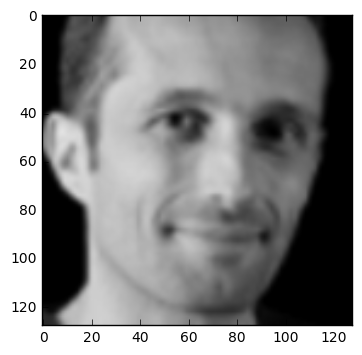

In [179]:
fn = '../data/cg.PNG'
fn = '../data/pp.png'

pp = scipy.misc.imread(fn)
pp = pp[:,:,0:3]
pp = scipy.misc.imresize(pp, (128,128))
plt.imshow(pp[:,:,0:3])
pp = np.mean(pp, axis=2, keepdims=True)

np.transpose([pp], (0, 3, 1, 2)).shape

## clearly indeed a male

In [183]:
'this a ' + {0 : "male", 1 : "female"}[int(modelGender.predict(np.transpose([pp], (0, 3, 1, 2)))>0.5)]

'this a male'